<a href="https://colab.research.google.com/github/chhyyi/aiffel/blob/main/LMS/exp12_summarizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aiffel LMS EXP12. summarizer 

일단 버전을 맞춥시다.

In [1]:
!pip3 list | grep tensorflow

tensorflow                    2.8.2+zzzcolab20220719082949
tensorflow-datasets           4.6.0
tensorflow-estimator          2.8.0
tensorflow-gcs-config         2.8.0
tensorflow-hub                0.12.0
tensorflow-io-gcs-filesystem  0.26.0
tensorflow-metadata           1.10.0
tensorflow-probability        0.16.0


In [2]:
#restart runtime required!!
!pip install tensorflow==2.6.0
!pip install keras==2.6.0
!pip install nltk==3.6.5
!pip install summa==1.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 564.4 MB 2.4 kB/s 
     |████████████████████████████████| 14.8 MB 7.9 MB/s 
     |████████████████████████████████| 132 kB 58.3 MB/s 
  Created wheel for clang: filename=clang-5.0-py3-none-any.whl size=30694 sha256=77dc9b14c065421f8c78246b1d4250ec122df814549b312556f685099a24d3ce
  Stored in directory: /root/.cache/pip/wheels/98/91/04/971b4c587cf47ae952b108949b46926f426c02832d120a082a
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68722 sha256=c50fbec0a2341ffc81646645ccb662530abfc77f4d0cbb31e9517eec1a93e003
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built clang wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typ

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 5.0 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 5.2 MB/s 
  Attempting uninstall: nltk
    Found existing installation: nltk 3.7
    Uninstalling nltk-3.7:
      Successfully uninstalled nltk-3.7
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 54 kB 2.4 MB/s 
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54412 sha256=6cbeee9ee5ce7f6ecc0ed3d91f9dbf47ec7d88c47541ff72a77ab0035d311747
  Stored in directory: /root/.cache/pip/wheels/29/64/ac/7b443477588d365ef37ada30d456bdf5f07dc5be9f6

In [1]:

import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# 1. 데이터 수집하기

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
data.sample(5)


,headlines,text
45004,US studying tardigrades to improve survival ra...,The US government's defence agency DARPA is ho...
97225,Govt asks MPs to attend 'Dangal' screening wit...,Lok Sabha Speaker Sumitra Mahajan has organise...
10892,Faizabad will be called Ayodhya from today: UP...,Uttar Pradesh Chief Minister Yogi Adityanath o...
7177,Those with big surnames came & went but found ...,"In an alleged jibe at the Nehru-Gandhi family,..."
93469,Hackers leak files showing NSA spied on int'l ...,Hacking group TheShadowBrokers has released do...


# 2. 추상적 요약: 데이터 전처리하기
- 불용어 적용 범위?

In [ ]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [ ]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [ ]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [8]:
 #나중에 비교를 위해 original index를 저장합니다. 인덱스를 바꿀 때마다 이걸 추가할 것입니다..
#data['orig_index']=range(len(data))
#print(data.tail())

                                               headlines  \
98396  CRPF jawan axed to death by Maoists in Chhatti...   
98397  First song from Sonakshi Sinha's 'Noor' titled...   
98398         'The Matrix' film to get a reboot: Reports   
98399  Snoop Dogg aims gun at clown dressed as Trump ...   
98400  Madhesi Morcha withdraws support to Nepalese g...   

                                                    text  orig_index  
98396  A CRPF jawan was on Tuesday axed to death with...       98396  
98397  'Uff Yeh', the first song from the Sonakshi Si...       98397  
98398  According to reports, a new version of the 199...       98398  
98399  A new music video shows rapper Snoop Dogg aimi...       98399  
98400  Madhesi Morcha, an alliance of seven political...       98400  


In [ ]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [ ]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [ ]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [ ]:
print(data['headlines'][0])

upGrad learner switches to career in ML & Al with 90% salary hike


In [ ]:
temp_text = str(data['text'][0])
temp_summary = str(data['headlines'][0])

print("text: ", preprocess_sentence(temp_text), '\n orginal: ', temp_text)
print("headlines:", preprocess_sentence(temp_summary, False),'\n orginal: ', temp_summary)  # 불용어를 제거하지 않습니다.

text:  saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers 
 orginal:  Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
headlines: upgrad learner switches to career in ml al with salary hike 
 orginal:  upGrad learner switches to career in ML & Al with 90% salary hike


In [ ]:
clean_text = []

for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

In [ ]:
clean_summary = []

for s in data['headlines']:
    clean_summary.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_summary[:5])

## 길이 맞추기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


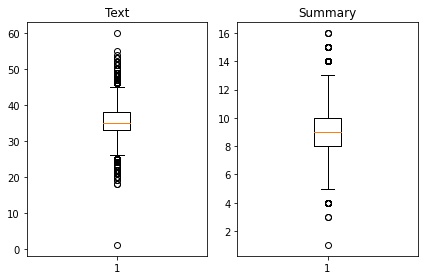

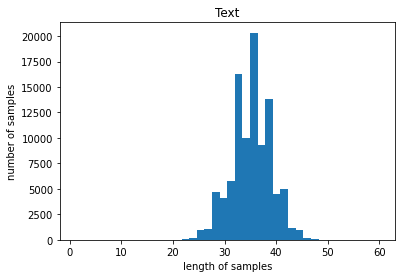

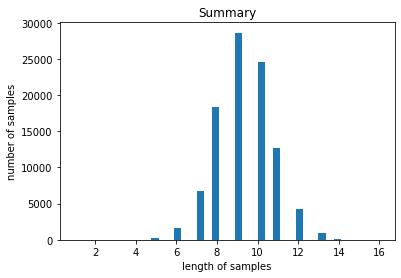

In [ ]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in clean_text]
summary_len = [len(s.split()) for s in clean_summary]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:

#데이터셋과 길이를 넣으면 그 이하인 것의 비율을 출력하는 함수
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

#이제 길이를 정해보아요. (이것은 임의로 정해진 것입니다.)
below_threshold_len(41, clean_text)
below_threshold_len(11, clean_summary)

전체 샘플 중 길이가 41 이하인 샘플의 비율: 0.9549613664091094
전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.9449877999186661


In [ ]:
#41, 11로 정하고 담아봅시다. 
#LMS에서는 조건식을 통해 array와 shape는 같고 Bool값이 들어있는 array를 데이터셋에 넣어서 하는데
#apply 쓰는건 판다스 df거고 고쳐서 해야겠네요.

text_max_len=41
summary_max_len=11
index_to_remain=[]
lim_text=np.array(clean_text.copy())
lim_summary=np.array(clean_summary.copy())
print('maxlen 적용 전 전체 샘플수 :', len(lim_text), len(lim_summary))
#better use np.where... but I did not planned to use numpy array so it is a bit dirty.

for i, text in enumerate(lim_text):
    index_to_remain.append(len(text.split())<=text_max_len or len(lim_summary[i].split())<=summary_max_len)

lim_text=lim_text[index_to_remain]
lim_summary=lim_summary[index_to_remain]

print('maxlen 적용 전 전체 샘플수 :', len(lim_text), len(lim_summary))

maxlen 적용 전 전체 샘플수 : 98360 98360
maxlen 적용 전 전체 샘플수 : 98130 98130


## summary에 시작/종료 토큰 추가하기
decoder는 input으로 시작 토큰이 있는 문자열을 받아 output으로 종료 토큰이 있는 문자열을 내놔야 합니다. 문자열은 그냥 더하면 됩니다.

In [ ]:
decoder_input=['sostoken '+x for x in lim_summary]
decoder_target=[x+' eostoken' for x in lim_summary]

print(type(decoder_input), type(decoder_target), type(lim_text))


<class 'list'> <class 'list'> <class 'numpy.ndarray'>


In [ ]:
#lms와 같이 일단 numpy array로 저장하겠습니다.
decoder_input=np.array(decoder_input)
decoder_target=np.array(decoder_target)

## train - valid data set 분리

In [ ]:
#먼저 numpy를 이용해 shuffle합니다.
indices = np.arange(decoder_input.shape[0])
np.random.shuffle(indices)
encoder_input = np.array(lim_text[indices])
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [ ]:
print(decoder_input)

In [ ]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19626


In [ ]:
encoder_input_train=encoder_input[:-n_of_val]
decoder_input_train=decoder_input[:-n_of_val]
decoder_target_train=decoder_target[:-n_of_val]

encoder_input_test=encoder_input[-n_of_val:]
decoder_input_test=decoder_input[-n_of_val:]
decoder_target_test=decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78504
훈련 레이블의 개수 : 78504
테스트 데이터의 개수 : 19626
테스트 레이블의 개수 : 19626


## 정수 인코딩

In [ ]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [ ]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69478
등장 빈도가 6번 이하인 희귀 단어의 수: 47314
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22164
단어 집합에서 희귀 단어의 비율: 68.09925444025447
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.4884067137868207


In [ ]:
src_vocab = 22000
src_tokenizer = Tokenizer(num_words=src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성


In [ ]:
# 텍스트 시퀀스를 정수 시퀀스로 변환 - encoder용
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[3973, 245, 1430, 3621, 587, 281, 358, 4830, 1177, 5944, 1415, 1540, 624, 141, 285, 188, 3973, 81, 6974, 7244, 624, 7154, 2066, 378, 25, 5944, 1415, 152, 624, 4685, 928, 6425, 876, 1977, 5944, 1415], [137, 1234, 858, 13822, 1, 132, 538, 2235, 383, 1586, 320, 100, 1323, 1215, 8837, 149, 3368, 10246, 7155, 405, 356, 538, 383, 42, 1215, 83, 7352, 2368, 7155, 1390, 7155, 7155, 583, 11, 948], [270, 666, 863, 7156, 7, 26, 818, 22, 1587, 6498, 1124, 101, 270, 1701, 71, 569, 830, 340, 5702, 71, 270, 123, 2417, 1749, 1, 270, 356, 71, 1701, 7, 569, 3, 33]]


In [ ]:
#정수 시퀀스로 변환 - decoder용
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)


In [ ]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30047
등장 빈도가 5번 이하인 희귀 단어의 수: 19622
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10425
단어 집합에서 희귀 단어의 비율: 65.30435650813725
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.664551611110355


In [ ]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 2050, 696, 3, 1172, 1323, 3, 325, 2193, 3, 3884], [1, 902, 1166, 172, 955, 30, 978, 11, 481, 42, 799], [1, 143, 864, 79, 1347, 4850, 5, 18, 35, 54, 4, 1061, 58], [1, 2194, 134, 730, 73, 3, 778, 15, 108, 2318, 225], [1, 221, 1315, 1324, 14, 7684, 5020, 2904, 314]]
target
decoder  [[2050, 696, 3, 1172, 1323, 3, 325, 2193, 3, 3884, 2], [902, 1166, 172, 955, 30, 978, 11, 481, 42, 799, 2], [143, 864, 79, 1347, 4850, 5, 18, 35, 54, 4, 1061, 58, 2], [2194, 134, 730, 73, 3, 778, 15, 108, 2318, 225, 2], [221, 1315, 1324, 14, 7684, 5020, 2904, 314, 2]]


In [ ]:
k=0
for i, v in tar_tokenizer.word_counts.items():
    print(i, v)
    k+=1
    if k>5:
        break

sostoken 78504
provide 116
way 326
to 49916
check 208
sims 4


In [ ]:
# 단어 tokenizer에서 제외된 단어만 있는 문장들 삭제
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78504
훈련 레이블의 개수 : 78504
테스트 데이터의 개수 : 19626
테스트 레이블의 개수 : 19626


In [ ]:
#padding
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')


# 3. 추상적 요약: 어텐션 메커니즘 사용하기

In [ ]:
## 일단 이대로 추출적 요약 해보기
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import AdditiveAttention


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])


# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 41)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 41, 128)      2816000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 41, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

### training model

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
307/307 [==============================] - 32s 69ms/step - loss: 6.0253 - val_loss: 5.5855
Epoch 2/50
307/307 [==============================] - 20s 64ms/step - loss: 5.4202 - val_loss: 5.1836
Epoch 3/50
307/307 [==============================] - 20s 64ms/step - loss: 5.0513 - val_loss: 4.8866
Epoch 4/50
307/307 [==============================] - 20s 64ms/step - loss: 4.7673 - val_loss: 4.6792
Epoch 5/50
307/307 [==============================] - 20s 64ms/step - loss: 4.5415 - val_loss: 4.5242
Epoch 6/50
307/307 [==============================] - 20s 64ms/step - loss: 4.3528 - val_loss: 4.4075
Epoch 7/50
307/307 [==============================] - 20s 64ms/step - loss: 4.1938 - val_loss: 4.3182
Epoch 8/50
307/307 [==============================] - 20s 64ms/step - loss: 4.0564 - val_loss: 4.2320
Epoch 9/50
307/307 [==============================] - 20s 64ms/step - loss: 3.9336 - val_loss: 4.1823
Epoch 10/50
307/307 [==============================] - 20s 64ms/step - loss: 3.823

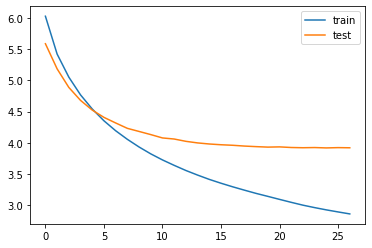

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# 4. 추상적 요약: 실제 결과와 요약문 비교하기

In [ ]:
#인퍼런스 모델 구현
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

In [ ]:
#for i in range(50, 100):
#    print("원문 :", seq2text(encoder_input_test[i]))
#    print("실제 요약 :", seq2summary(decoder_input_test[i]))
#    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
#    print("\n")
#아래에 같이 출력해서 생략

# 5. Summa를 이용한 추출적 요약

바로 위의 결과와 비교해볼까요? 그런데 전처리 전의 문장을 넣어야 합니다. 처리를 다 반복하면 되겠습니다. 순서대로 짚어봅시다.
1. data['text'] 에서 시작하면 되겠습니다. data['text'] #pandas df

2. clean_text[i] = preprocess_sentence(data['text']) #불용처 처리
3. lim_text[?] = clean_text[index_to_remain[i]]
4. lim_text[?] = lim_text[indices[?]]
5. encoder_input
6. encoder_input_train -> 이런 것이 들어가게 됩니다.



결국 decode_sequence()에 넣을 sequence를 만들면 되는데요, 

In [ ]:
print(data['text'][55])
print(texts)
print(input_texts)
#print(list(input_seq[0].split())[:text_max_len])

In [ ]:
for i in range(55,100):
    texts=preprocess_sentence(data['text'][i], True) #remove stopwords : summarize가 아닌 text에 대해서만
    input_texts=src_tokenizer.texts_to_sequences(texts)
    input_seq=pad_sequences(input_texts, maxlen=text_max_len, padding='post')
    print("원문 :", data['text'][i])
    print("실제 요약 :", data['headlines'][i])
    print("예측 요약 :", decode_sequence(input_seq.split()[:text_max_len]))
    for j in range(5,20):
        summ_extract=summarize(texts,words=j)
        if len(summ_extract):
            print("추출적 요약 :", summ_extract)
            break
        print('failed to find extracted summary', len(summ_extract))
    print("\n")

원문 : Actress Mishti, who has featured in 'Manikarnika: The Queen of Jhansi', has said the film's co-director Kangana Ranaut made false promises to the cast. "Kangana had said, 'I want dates because all characters look jumbled up...I'm trying my best to give everybody a prominent space on screen.' After watching the movie, there is no scope for other characters," Mishti added. 
실제 요약 : Kangana made fake promises to cast: 'Manikarnika' actress Mishti


ValueError: ignored

In [ ]:
import requests
from summa.summarizer import summarize

for i in range(55, 70):
    texts=clean_text[indices[i]]
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    for j in range(5,50):
        summ_extract=summarize(texts, words=j)
        if len(summ_extract)>1:
            print("추출적 요약 :", summ_extract)
            break
    print("\n")

원문 : undefeated professional boxer floyd mayweather jr announced retirement knocking mma champion conor mcgregor richest fight history chose right dance partner last dance final fight said mayweather american ends career unbeaten professional record surpassing former boxer rocky marciano career record 
실제 요약 : mayweather retires after out mcgregor in richest fight 
예측 요약 :  mayweather mcgregor floyd mayweather to be auctioned


원문 : indians make total child brides world according india report nearly million indians married estimated million girls added stated elimination girl child marriages help avoid neonatal deaths infant deaths child deaths 
실제 요약 : child brides in the world are indian report 
예측 요약 :  indian origin man to get married in


원문 : minister nitin gadkari friday announced world bank backed crore scheme improve irrigation facilities water accessibility capacity several states including maharashtra karnataka telangana gadkari also announced crore worth daman ganga inter s

# 회고, 토의  
아무래도 우리말에 대한 자료는 한계가 있나보다. 결국 그냥 영어로 하고 있다. 얼마 전부터 lms의 코드를 거의 그대로 갖다 쓰고 있다. 추출적 요약의 경우 퍼실님께 미리 힌트를 받아서 전처리 전의 데이터를 그대로 

원문 : indian spinner kuldeep yadav registered debut saturday said variation taught australian legend shane warne got david warner wicket international career first wicket kuldeep taken warne coach anil kumble session later australia matthew wade said yadav variations hard pick   
실제 요약 : taught by warne got me warner wicket kuldeep   
예측 요약 :  kuldeep yadav calls kuldeep yadav kuldeep yadav  
추출적 요약 : At least one soldier was killed and three others   injured in a suspected IED explosion in Manipur's Tengnoupal district on Monday.

# 지푸라기 잡는 식의 시도들 - to figure out the condition summarize work

In [ ]:
summarize(texts,ratio=1)

''

In [ ]:
texts=lim_text[5]
summ_extract=summarize(texts, ratio=100)
print(texts)
print(summ_extract)

india recorded lowest odi total new zealand getting runs overs fourth odi hamilton thursday seven india batsmen dismissed single digit scores number ten batsman yuzvendra chahal top scored india previous lowest odi total new zealand



NameError: ignored

In [ ]:
import requests
from summa.summarizer import summarize


In [ ]:
summarize(temp_text,ratio=0.5)

"upGrad's Online Power Learning has powered 3 lakh+ careers."

In [ ]:
!pip install nltk==3.6.5
!pip install summa==1.2.0
print(temp_text)
print(preprocess_sentence(temp_text))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 5.1 MB/s 
  Attempting uninstall: nltk
    Found existing installation: nltk 3.7
    Uninstalling nltk-3.7:
      Successfully uninstalled nltk-3.7
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 54 kB 2.1 MB/s 
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54412 sha256=9c2838f29a4445e12cbfc86512a7b22bdc61481cb1004070123922ec5fc7a16f
  Stored in directory: /root/.cache/pip/wheels/29/64/ac/7b443477588d365ef37ada30d456bdf5f07dc5be9f6324cb6e
Successfully built summa


NameError: ignored

In [ ]:
summarize("""saurav kant, an alumnus upgrad program of machine learning artificial intelligence of sr systems engineer providing infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers
""",words=20)

''

In [ ]:
for i in range (1,375):
    summarized=summarize(temp_text[:189],words=i)
    if len(summarized)>0:
        print('words=', i)
        print(summarized)
        break

words= 15
Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience.


In [ ]:
len(temp_text)

375

In [ ]:
print(temp_text[:189])

Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The p


In [ ]:
aa=preprocess_sentence(temp_text)
aa='''india recorded lowest odi total new zealand getting runs overs fourth odi hamilton thursday seven india batsmen dismissed single digit scores number ten batsman yuzvendra chahal top scored india previous lowest odi Total new zealand'''
for i in range (1,375):
#    summarized=summarize(aa+'. The E',words=i)
    summarized=summarize(aa,words=i)
    if len(summarized)>0:
        print('words=', i)
        print(summarized)
        break


words= 8
india recorded lowest odi total new zealand getting runs overs fourth odi hamilton thursday seven.


In [ ]:
print(aa)

saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers
